## HCP Eigen Modes notebook

In [1]:
%load_ext blackcellmagic

In [1]:
%%capture --no-display

# import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.spatial import distance

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, runforward

In [2]:
# this function needs to be incorporated into spectrome?
def get_meanC(Call):
    # C = np.mean(Call, axis = 2)
    C = (Call + np.transpose(Call)) / 2
    ss = np.sort(C[:])[::-1]
    C = np.minimum(C, ss[np.round(0.01 * len(ss)).astype("int")])
    return C

In [3]:
# Some house keeping
hcp_dir = "./../../data"

# Define frequency range of interest
fmin = 2  # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin, fmax, 40)
f2w = np.abs(fvec - 10).argmin()  # 8th index = alpha ~10hz
w = 2 * np.pi * fvec[f2w]

# Load Pablo's Yeo 2017 canonical network maps
com_dk = np.load(
    "../../data/com_dk.npy"
).item()
DK_df_normalized = pd.read_csv(
    "../../data/DK_dictionary_normalized.csv"
).set_index("Unnamed: 0")
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])
# Create FC network jupyter widget for visiualization
fc_names = [
    "Visual",
    "Limbic",
    "Default",
    "Somatomotor",
    "Frontoparietal",
    "Ventral_Attention",
    "Dorsal_Attention",
]

We need to threshold so that the amount of non-zero elements in the eigenmodes are similar to the support of the canonical networks they are being compared to. Plot the distribution of these canonical network's region-wise weights first.

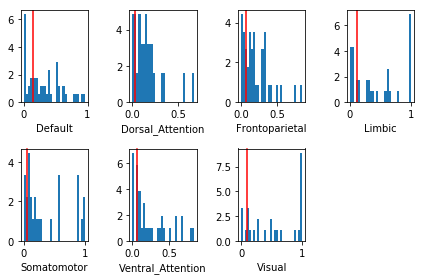

In [4]:
p = 1
for names in DK_df_normalized.index:
    y = np.nan_to_num(DK_df_normalized.loc[names].values)
    u = np.mean(y)
    s = np.std(y)
    plt.subplot(2, 4, p)
    plt.hist(y[np.nonzero(y)], 30, density=True)
    plt.xlabel(names)
    plt.axvline(u - s * 0.2, color="r")
    p += 1

plt.tight_layout()

In [5]:
## Printing out the mean and standard deviation for each canonical network, stats for thresholding
xall = []
for names in DK_df_normalized.index:
    x = np.count_nonzero(DK_df_normalized.loc[names].values)
    u = np.mean(np.nan_to_num(DK_df_normalized.loc[names].values))
    s = np.std(np.nan_to_num(DK_df_normalized.loc[names].values))
    xall.append(x)
    print("Number of non zeros elements in {} network is {}".format(names, x))
    print("{} network's mean is {}".format(names, u))
    print("{} network's standard deviation is {}".format(names, s))

print("Average number of non-zero elements is {}".format(np.mean(xall)))

Number of non zeros elements in Default network is 62
Default network's mean is 0.19331434987496474
Default network's standard deviation is 0.2572601143670553
Number of non zeros elements in Dorsal_Attention network is 36
Dorsal_Attention network's mean is 0.0528080257964081
Dorsal_Attention network's standard deviation is 0.1157064069215022
Number of non zeros elements in Frontoparietal network is 48
Frontoparietal network's mean is 0.09806281787307308
Frontoparietal network's standard deviation is 0.16885544819610704
Number of non zeros elements in Limbic network is 43
Limbic network's mean is 0.175685178720891
Limbic network's standard deviation is 0.3195720484960755
Number of non zeros elements in Somatomotor network is 35
Somatomotor network's mean is 0.11406184813409133
Somatomotor network's standard deviation is 0.2576382009425513
Number of non zeros elements in Ventral_Attention network is 45
Ventral_Attention network's mean is 0.10579581613816773
Ventral_Attention network's st

### Actually binarizing according to threshold

In [6]:
# binarize according to threshold:
# threshold, ub, lb = 0.2, 1, 0, no longer using the 0.2, we will use threshold = mean-0.1*std
ub, lb = 1, 0

DKfc_binarized = pd.DataFrame(
    [], index=DK_df_normalized.index, columns=DK_df_normalized.columns
)
for name in DK_df_normalized.index:
    u = np.mean(np.nan_to_num(DK_df_normalized.loc[name].values))
    s = np.std(np.nan_to_num(DK_df_normalized.loc[name].values))
    threshold = u - s * 0.1
    DKfc_binarized.loc[name] = np.where(
        DK_df_normalized.loc[name].values > threshold, ub, lb
    )
    print(
        "Number of non-zero elements in {} network is {}".format(
            name, np.count_nonzero(DKfc_binarized.loc[name].values)
        )
    )

DKfc_binarized

Number of non-zero elements in Default network is 32
Number of non-zero elements in Dorsal_Attention network is 22
Number of non-zero elements in Frontoparietal network is 29
Number of non-zero elements in Limbic network is 22
Number of non-zero elements in Somatomotor network is 22
Number of non-zero elements in Ventral_Attention network is 24
Number of non-zero elements in Visual network is 20


,ctx-lh-bankssts,ctx-lh-caudalanteriorcingulate,ctx-lh-caudalmiddlefrontal,ctx-lh-cuneus,ctx-lh-entorhinal,ctx-lh-fusiform,ctx-lh-inferiorparietal,ctx-lh-inferiortemporal,ctx-lh-isthmuscingulate,ctx-lh-lateraloccipital,...,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus,Right-Amygdala,Right-Accumbens-area,Right-VentralDC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
Default,1,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
Dorsal_Attention,0,0,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Frontoparietal,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Limbic,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,1,1,0
Somatomotor,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ventral_Attention,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Visual,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0


## Creating HCP Brain object

In [7]:
HCP_brain = Brain.Brain()
HCP_brain.add_connectome(hcp_dir)
HCP_brain.reorder_connectome(HCP_brain.connectome, HCP_brain.distance_matrix)
HCP_brain.bi_symmetric_c()
HCP_brain.reduce_extreme_dir()
HCP_brain.add_laplacian_eigenmodes(
    w=w,
    alpha=1,
    speed=10,
    num_ev=86,
)
HCP_brain.norm_eigenmodes.shape

(86, 86)

#### Visualize both the connectome and eigenmodes:

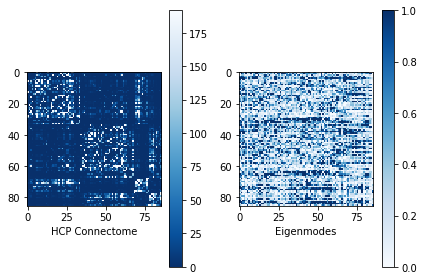

In [8]:
plt.subplot(1,2,1)
plt.imshow(HCP_brain.reducedConnectome, cmap=plt.cm.Blues_r)
plt.colorbar()
plt.xlabel('HCP Connectome')
plt.subplot(1,2,2)
plt.imshow(HCP_brain.norm_eigenmodes,cmap=plt.cm.Blues)
plt.xlabel('Eigenmodes')
plt.colorbar()
plt.tight_layout()

Text(0.5, 0, 'Eigenmode #')

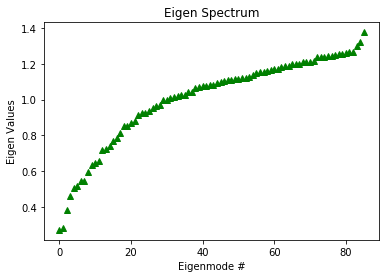

In [9]:
# plot eigen spectrum
plt.plot(np.abs(HCP_brain.eigenvalues),'g^')
plt.title('Eigen Spectrum')
plt.ylabel('Eigen Values')
plt.xlabel('Eigenmode #')

In [10]:
## Polar coordinates with imaginary/axis + frequency response of eigenmodes
default_params = (
    HCP_brain.ntf_params
)  # re-defining the default parameters for the model
default_params[
    "speed"
] = (
    15
)  # change default speed to 10 to stay consistent with the rest of the eigenmode analysis defaults

default_params[
    "alpha"
] = (
    0.5
)

freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)

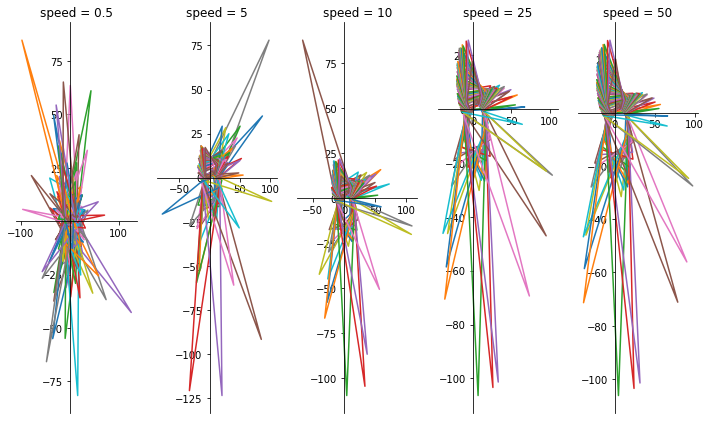

In [11]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, sharey = False, figsize = (10,6))
default_params["alpha"] = 0.5
default_params["speed"] = 0.5
freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)
ax1.plot(frequency_response[:,:].real, frequency_response[:,:].imag)
ax1.spines["left"].set_position("zero")
ax1.spines["right"].set_color("none")
ax1.spines["bottom"].set_position("zero")
ax1.spines["top"].set_color("none")
ax1.title.set_text("speed = {}".format(default_params["speed"]))

#plt.subplot(1,5,2)
default_params["speed"] = 5
freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)
ax2.plot(frequency_response[:,:].real, frequency_response[:,:].imag)
ax2.spines["left"].set_position("zero")
ax2.spines["right"].set_color("none")
ax2.spines["bottom"].set_position("zero")
ax2.spines["top"].set_color("none")
ax2.title.set_text("speed = {}".format(default_params["speed"]))

#plt.subplot(1,5,3)
default_params["speed"] = 10
freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)
ax3.plot(frequency_response[:,:].real, frequency_response[:,:].imag)
ax3.spines["left"].set_position("zero")
ax3.spines["right"].set_color("none")
ax3.spines["bottom"].set_position("zero")
ax3.spines["top"].set_color("none")
ax3.title.set_text("speed = {}".format(default_params["speed"]))

#plt.subplot(1,5,4)
default_params["speed"] = 25
freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)
ax4.plot(frequency_response[:,:].real, frequency_response[:,:].imag)
ax4.spines["left"].set_position("zero")
ax4.spines["right"].set_color("none")
ax4.spines["bottom"].set_position("zero")
ax4.spines["top"].set_color("none")
ax4.title.set_text("speed = {}".format(default_params["speed"]))

#plt.subplot(1,5,5)
default_params["speed"] = 50
freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)
ax5.plot(frequency_response[:,:].real, frequency_response[:,:].imag)
ax5.spines["left"].set_position("zero")
ax5.spines["right"].set_color("none")
ax5.spines["bottom"].set_position("zero")
ax5.spines["top"].set_color("none")
ax5.title.set_text("speed = {}".format(default_params["speed"]))
plt.tight_layout()

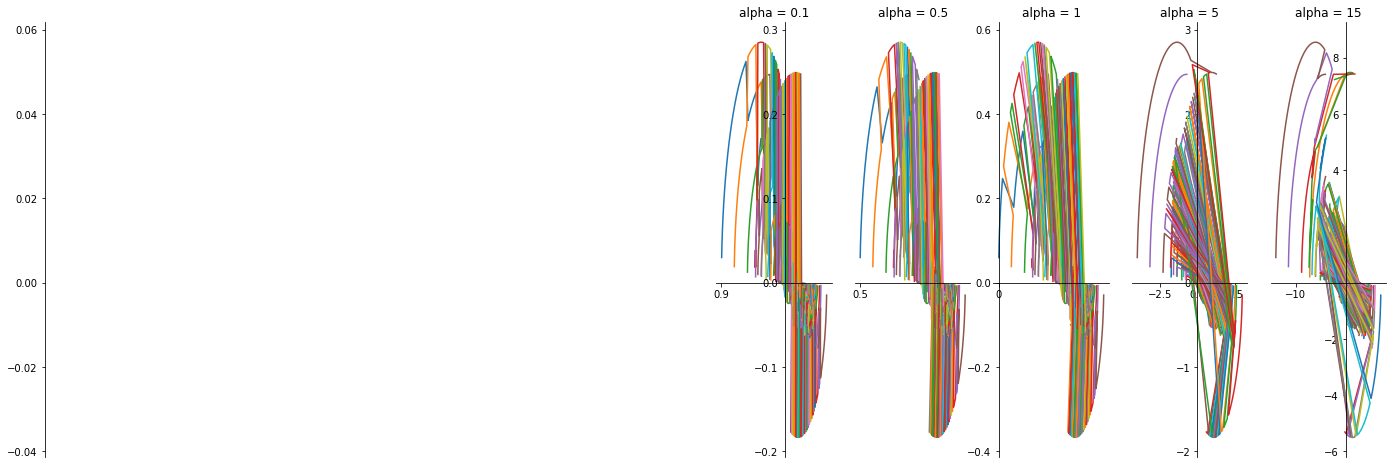

In [13]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, sharey = False, figsize = (12,8))
default_params["alpha"] = 0.1
default_params["speed"] = 10
freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)
ax1.plot(ev[:,:].real, ev[:,:].imag)
ax1.spines["left"].set_position("zero")
ax1.spines["right"].set_color("none")
ax1.spines["bottom"].set_position("zero")
ax1.spines["top"].set_color("none")
ax1.title.set_text("alpha = {}".format(default_params["alpha"]))

default_params["alpha"] = 0.5
freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)
ax2.plot(ev[:,:].real, ev[:,:].imag)
ax2.spines["left"].set_position("zero")
ax2.spines["right"].set_color("none")
ax2.spines["bottom"].set_position("zero")
ax2.spines["top"].set_color("none")
ax2.title.set_text("alpha = {}".format(default_params["alpha"]))

default_params["alpha"] = 1
freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)
ax3.plot(ev[:,:].real, ev[:,:].imag)
ax3.spines["left"].set_position("zero")
ax3.spines["right"].set_color("none")
ax3.spines["bottom"].set_position("zero")
ax3.spines["top"].set_color("none")
ax3.title.set_text("alpha = {}".format(default_params["alpha"]))

default_params["alpha"] = 5
freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)
ax4.plot(ev[:,:].real, ev[:,:].imag)
ax4.spines["left"].set_position("zero")
ax4.spines["right"].set_color("none")
ax4.spines["bottom"].set_position("zero")
ax4.spines["top"].set_color("none")
ax4.title.set_text("alpha = {}".format(default_params["alpha"]))

default_params["alpha"] = 15
freq_model, frequency_response, ev, vv = runforward.run_forward(HCP_brain, default_params, fvec)
ax5.plot(ev[:,:].real, ev[:,:].imag)
ax5.spines["left"].set_position("zero")
ax5.spines["right"].set_color("none")
ax5.spines["bottom"].set_position("zero")
ax5.spines["top"].set_color("none")
ax5.title.set_text("alpha = {}".format(default_params["alpha"]))

### Plot the spectrum of the following: $[j\omega I + L_{\alpha}(\omega)]^{-1}$
### Also look at very low speed ranges, and see how sensitive coupling $\alpha$ is at low speeds

Text(0.5, 1.0, 'Frequency Response of Each Eigenmode')

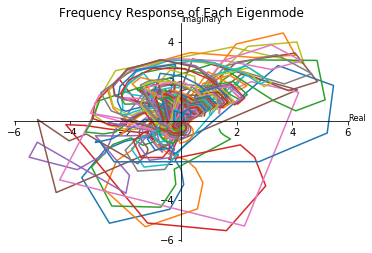

In [14]:
## Plotting the real vs. imaginary portions
fig, ax = plt.subplots()
ax.plot(frequency_response[:,:].real, frequency_response[:,:].imag)
ax.spines["left"].set_position("zero")
ax.spines["right"].set_color("none")
ax.spines["bottom"].set_position("zero")
ax.spines["top"].set_color("none")
plt.text(6, 0, "Real", fontsize=8)
plt.text(0, 5, "Imaginary", fontsize=8)
plt.title("Frequency Response of Each Eigenmode")

### Binarize eigenmodes:

In [15]:
# firstly, what is the average number of non-zero elements in the canonical networks?
print(
    "We want to binarize the eigenmodes so that there are about {} non-zero elements.".format(
        np.round(np.mean(np.count_nonzero(DKfc_binarized.values, axis=1)))
    )
)

We want to binarize the eigenmodes so that there are about 24.0 non-zero elements.


In [16]:
thresh_vec = np.linspace(0.1, 1, 10)
binary_count = np.zeros(thresh_vec.shape)
for i in np.arange(0, len(thresh_vec)):
    binary_mat = np.where(HCP_brain.norm_eigenmodes > thresh_vec[i], ub, lb)
    binary_count[i] = np.around(np.mean(np.count_nonzero(binary_mat, axis=1)))

binary_count  # looks like we pick the entry that give us 26, which is i = 5, 6th entry

array([68., 56., 46., 38., 31., 26., 21., 17., 14.,  0.])

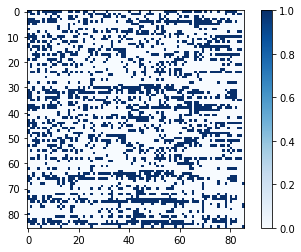

In [17]:
HCP_brain.binary_eigenmodes = np.where(
    HCP_brain.norm_eigenmodes > thresh_vec[5], ub, lb
)
plt.imshow(HCP_brain.binary_eigenmodes, cmap=plt.cm.Blues)
plt.colorbar()

## Dice dissimilarity metric first:

In [18]:
hcp_dice = eigenmode.get_dice_df(HCP_brain.binary_eigenmodes, DKfc_binarized)
hcp_dice.head(10).style.set_caption("HCP Eigenmode Dice Coef").apply(
    functions.highlight_min, axis=1
)

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
Eig #1,0.705882,0.793103,0.815385,0.448276,0.689655,0.766667,0.5
Eig #2,0.733333,0.96,0.754386,0.6,0.6,0.615385,0.833333
Eig #3,0.636364,0.928571,0.809524,0.321429,1,0.931034,0.481481
Eig #4,0.666667,0.863636,0.686275,0.5,1,0.869565,0.52381
Eig #5,0.419355,0.923077,0.627119,0.692308,0.615385,0.592593,0.84
Eig #6,1,1,1,1,1,1,0.833333
Eig #7,0.606557,1,0.793103,0.333333,0.803922,0.811321,0.673469
Eig #8,0.535714,0.826087,0.660377,0.73913,0.608696,0.541667,0.909091
Eig #9,0.6,0.92,0.824561,0.52,0.76,0.884615,0.583333
Eig #10,0.6,0.818182,0.870968,0.490909,0.636364,0.789474,0.698113


In [19]:
# Compute entropy
hcp_dice_entropy = eigenmode.get_entropy_score(hcp_dice)
df_hcp_dice_entropy = pd.DataFrame(
    hcp_dice_entropy, index=hcp_dice.index, columns=[("Entropy")]
)
order_index = df_hcp_dice_entropy.sort_values(by="Entropy", ascending=True).index
ordered_dice = hcp_dice.reindex(order_index)
ordered_entropy = df_hcp_dice_entropy.reindex(order_index)
sorted_entropy_hcp_dice = ordered_dice.join(ordered_entropy)
sorted_entropy_hcp_dice.head(25).style.set_caption(
    "HCP eigenmode dice sorted by Entropy"
).apply(functions.highlight_min, subset=ordered_dice.columns, axis=1)

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual,Entropy
Eig #3,0.636364,0.928571,0.809524,0.321429,1,0.931034,0.481481,1.88748
Eig #74,0.833333,0.789474,0.911111,0.526316,1,1,0.388889,1.90255
Eig #7,0.606557,1,0.793103,0.333333,0.803922,0.811321,0.673469,1.90543
Eig #75,0.627119,0.836735,0.785714,0.469388,0.877551,0.882353,0.489362,1.91727
Eig #4,0.666667,0.863636,0.686275,0.5,1,0.869565,0.52381,1.91732
Eig #77,0.660377,0.953488,0.8,0.581395,1,0.955556,0.512195,1.91755
Eig #63,0.5,0.72,0.508772,0.6,0.84,0.730769,1,1.91755
Eig #64,0.457627,0.714286,0.5,0.673469,0.836735,0.72549,0.957447,1.91804
Eig #57,0.47541,0.921569,0.586207,0.529412,0.882353,0.773585,0.795918,1.9184
Eig #21,0.684211,0.914894,0.925926,0.404255,0.659574,0.795918,0.733333,1.91844


## Heatmaps of eigenmode vs. speed/alpha per network

alpha first, at constant speed:

In [101]:
# create vector of alpha and speed values:
alpha_vec = np.linspace(0,2,5)
speed_vec = np.linspace(0.5,30,5)
num_fc = hcp_dice.shape[1]
num_emode = hcp_dice.shape[0]

#hcp_dice, create empy object with connectome
alpha_brain = Brain.Brain()
alpha_brain.add_connectome(hcp_dir)
alpha_brain.reorder_connectome(alpha_brain.connectome, alpha_brain.distance_matrix)
alpha_brain.bi_symmetric_c()
alpha_brain.reduce_extreme_dir()

alpha_dice = np.zeros((num_emode, num_fc, len(alpha_vec)))
current_speed = 10
for avec in np.arange(0,len(alpha_vec)):
    alpha_brain.add_laplacian_eigenmodes(
        w=w,
        alpha=alpha_vec[avec],
        speed=current_speed,
        num_ev=86,
    )
    # next binarize according to threshold: 
    alpha_brain.binary_eigenmodes = np.where(
    alpha_brain.norm_eigenmodes > thresh_vec[5], ub, lb
    )
    alpha_dice[:,:,avec] = eigenmode.get_dice_df(alpha_brain.binary_eigenmodes, DKfc_binarized)
    

### Visualize eigenmode dice scores as we increase $\alpha$

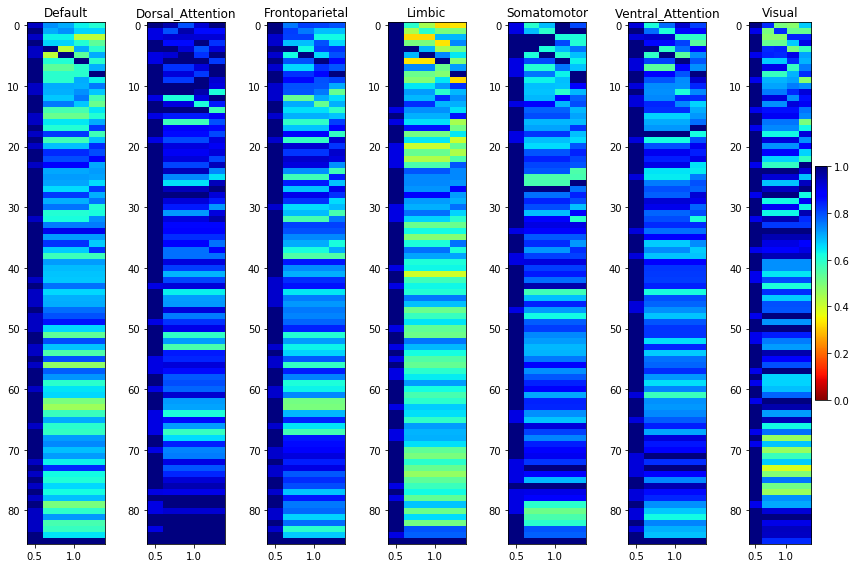

In [94]:
alphafig,(im1,im2,im3,im4,im5,im6,im7) = plt.subplots(1,7, figsize = (12,8))
im1.imshow(alpha_dice[:,0,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
im1.title.set_text("Default")
im1.set_xticklabels(alpha_vec)

im2.imshow(alpha_dice[:,1,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
im2.title.set_text(DKfc_binarized.index[1])
im2.set_xticklabels(alpha_vec)

im3.imshow(alpha_dice[:,2,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
im3.title.set_text(DKfc_binarized.index[2])
im3.set_xticklabels(alpha_vec)

im4.imshow(alpha_dice[:,3,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
im4.title.set_text(DKfc_binarized.index[3])
im4.set_xticklabels(alpha_vec)

im5.imshow(alpha_dice[:,4,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
im5.title.set_text(DKfc_binarized.index[4])
im5.set_xticklabels(alpha_vec)

im6.imshow(alpha_dice[:,5,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
im6.title.set_text(DKfc_binarized.index[5])
im6.set_xticklabels(alpha_vec)

im = im7.imshow(alpha_dice[:,6,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
im7.title.set_text(DKfc_binarized.index[6])
im7.set_xticklabels(alpha_vec)

plt.colorbar(im)
plt.tight_layout()

Speed changing, holding alpha constant:

In [62]:
#hcp_dice, create empy object with connectome
speed_brain = Brain.Brain()
speed_brain.add_connectome(hcp_dir)
speed_brain.reorder_connectome(speed_brain.connectome, speed_brain.distance_matrix)
speed_brain.bi_symmetric_c()
speed_brain.reduce_extreme_dir()

speed_dice = np.zeros((num_emode, num_fc, len(speed_vec)))
current_alpha = 1
for svec in np.arange(0,len(speed_vec)):
    speed_brain.add_laplacian_eigenmodes(
        w=w,
        alpha=current_alpha,
        speed=speed_vec[svec],
        num_ev=86,
    )
    # next binarize according to threshold: 
    speed_brain.binary_eigenmodes = np.where(
    speed_brain.norm_eigenmodes > thresh_vec[5], ub, lb
    )
    speed_dice[:,:,svec] = eigenmode.get_dice_df(speed_brain.binary_eigenmodes, DKfc_binarized)


visualize speed:

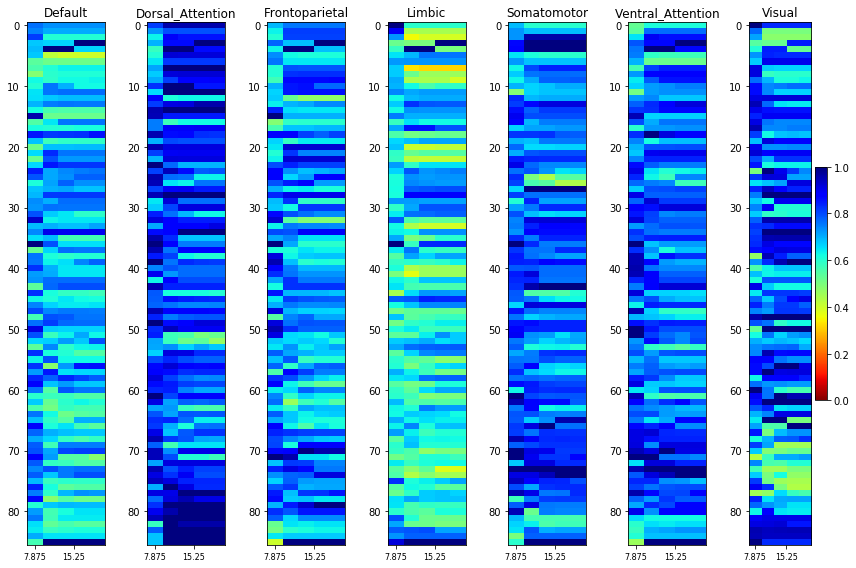

In [102]:
spdfig,(ims1,ims2,ims3,ims4,ims5,ims6,ims7) = plt.subplots(1,7, figsize = (12,8))
ims1.imshow(speed_dice[:,0,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
ims1.title.set_text("Default")
ims1.set_xticklabels(speed_vec,fontsize = 8)

ims2.imshow(speed_dice[:,1,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
ims2.title.set_text(DKfc_binarized.index[1])
ims2.set_xticklabels(speed_vec,fontsize = 8)

ims3.imshow(speed_dice[:,2,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
ims3.title.set_text(DKfc_binarized.index[2])
ims3.set_xticklabels(speed_vec,fontsize = 8)

ims4.imshow(speed_dice[:,3,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
ims4.title.set_text(DKfc_binarized.index[3])
ims4.set_xticklabels(speed_vec,fontsize = 8)

ims5.imshow(speed_dice[:,4,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
ims5.title.set_text(DKfc_binarized.index[4])
ims5.set_xticklabels(speed_vec,fontsize = 8)

ims6.imshow(speed_dice[:,5,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
ims6.title.set_text(DKfc_binarized.index[5])
ims6.set_xticklabels(speed_vec,fontsize = 8)

ims = ims7.imshow(speed_dice[:,6,:],vmin=0, vmax=1, cmap='jet_r', aspect='auto')
ims7.title.set_text(DKfc_binarized.index[6])
ims7.set_xticklabels(speed_vec,fontsize = 8)
plt.colorbar(ims)
plt.tight_layout()

## Overlap score next:

In [19]:
%%capture --no-display
## HCP with overlap - reproduce results from previous notebook:

# For each eigen vector, compute standard Z for all FC networks, then do this for all eigen vectors
hcp_overlap_score, hcp_sxy = eigenmode.get_overlap_score_dfs(HCP_brain.norm_eigenmodes,DKfc_binarized, threshold = threshold)

#hcp_sxy.head(10).style.apply(functions.highlight_max, axis = 1)

hcp_overlap_score.head(10).style.apply(functions.highlight_max,axis = 1)

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
Eig #1,-1.07791,-0.537178,-0.958127,1.12725,-1.60806,-2.3206,1.95017
Eig #2,-0.201391,-1.36161,-0.547797,-1.49304,0.538569,0.132003,-0.987249
Eig #3,1.09797,-1.93559,0.670943,2.93607,-3.43927,-0.522698,1.51938
Eig #4,-1.09989,-2.89438,-1.41603,2.49345,-0.257583,0.627925,-1.18113
Eig #5,3.71692,-1.12816,1.85861,1.08675,-0.0317617,1.23373,0.724597
Eig #6,0.513294,-1.05421,1.62095,-0.643542,-0.180957,0.362559,-1.67225
Eig #7,1.79774,-1.02347,-1.23218,1.86062,0.709711,-1.35129,1.54953
Eig #8,1.81441,-0.363111,3.36036,0.824865,-1.66362,0.402441,-2.54255
Eig #9,2.11414,-1.90618,-0.819701,2.0401,-2.49033,-3.80307,0.644223
Eig #10,-0.0871838,-3.31678,-2.94926,1.30513,-0.383314,-1.56873,0.38588


In [60]:
# compute entropy for overlap
entropy_hcp_overlap = eigenmode.get_entropy_score(hcp_sxy)
df_olentropy_hcp = pd.DataFrame(entropy_hcp_overlap, index = hcp_dice.index, columns = [('Entropy')])
order_index = df_olentropy_hcp.sort_values(by = 'Entropy', ascending = True).index
ordered_overlap = hcp_sxy.reindex(order_index)
ordered_olentropy = df_olentropy_hcp.reindex(order_index)
sorted_olentropy_hcp = ordered_overlap.join(ordered_olentropy)
sorted_olentropy_hcp.head(25).style.set_caption('HCP eigenmode OVERLAP SCORE sorted by Entropy').apply(functions.highlight_max, subset = ordered_overlap.columns, axis = 1)

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual,Entropy
Eig #86,0.166667,0,0,0.5,0,0,0.333333,1.0114
Eig #85,0.416667,0.138889,0.333333,0.361111,0.333333,0.305556,0.111111,1.86594
Eig #81,0.459016,0.213115,0.327869,0.344262,0.278689,0.311475,0.114754,1.88251
Eig #29,0.37931,0.206897,0.362069,0.241379,0.258621,0.310345,0.103448,1.88489
Eig #38,0.440678,0.20339,0.338983,0.237288,0.169492,0.186441,0.20339,1.88622
Eig #6,0.4,0.2,0.425,0.225,0.25,0.3,0.15,1.88835
Eig #9,0.4375,0.203125,0.3125,0.3125,0.1875,0.171875,0.25,1.89555
Eig #33,0.363636,0.242424,0.378788,0.257576,0.181818,0.257576,0.136364,1.89558
Eig #15,0.38806,0.179104,0.358209,0.238806,0.238806,0.283582,0.149254,1.89759
Eig #3,0.409836,0.196721,0.360656,0.344262,0.147541,0.262295,0.278689,1.89804


## PCA

In [39]:
from sklearn.decomposition import PCA

In [52]:
hcp_best_label = np.zeros([1,86])
iter_label = 0
for label in hcp_dice.index:
    iter_eigen = pd.to_numeric(hcp_dice.loc[label,:])
    best_network = iter_eigen.idxmin(axis = 0) # find highest overlap score
    hcp_best_label[0,iter_label] = hcp_dice.columns.get_loc(best_network)
    iter_label += 1
    
hcp_best_label = hcp_best_label.reshape(86)

In [58]:
pca = PCA(n_components = 3)
projected = pca.fit_transform(hcp_dice.values)
projected.shape

(86, 3)

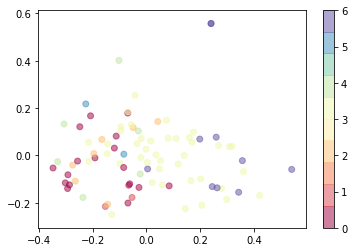

In [62]:
plt.scatter(projected[:, 0], projected[:, 1],
            c = hcp_best_label, alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
#plt.xlabel('component 1')
#plt.ylabel('component 2')
plt.colorbar();

## Get number of eigen modes belonging to each network and visualize for each type of metric:

In [61]:
df_test = pd.DataFrame(np.zeros([1,hcp_dice.shape[1]]), columns = hcp_dice.columns)

In [62]:
df_test.rename(index={0:'HCP_Dice'})

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
HCP_Dice,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
#first do DICE and HCP:
df_networks = pd.DataFrame(np.zeros([1,hcp_dice.shape[1]]),columns = hcp_dice.columns)
for sortedeigen in sorted_entropy_hcp_dice.index:
    iter_eigen = pd.to_numeric(sorted_entropy_hcp_dice.loc[sortedeigen,:])
    best_network = iter_eigen.idxmin(axis = 0) # find which network has lowest Dice
    # +1 count for whichever network has the lowest Dice
    df_networks[best_network] += 1
    
df_networks = df_networks.rename(index={0:'HCP_Dice'})

In [67]:
#Then overlap and HCP:
new_df = pd.DataFrame(np.zeros([1,hcp_dice.shape[1]]),columns = hcp_dice.columns)
for sortedeigen in hcp_sxy.index:
    iter_eigen = pd.to_numeric(hcp_sxy.loc[sortedeigen,:])
    best_network = iter_eigen.idxmax(axis = 0) # find highest overlap score
    # +1 count for network with highest overlap
    new_df[best_network] += 1

new_df = new_df.rename(index={0:'HCP_overlap'})
df_networks.append(new_df)

Unnamed: 0,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
HCP_Dice,18.0,2.0,7.0,41.0,6.0,2.0,10.0
HCP_overlap,75.0,0.0,9.0,2.0,0.0,0.0,0.0


In [80]:
test_networks = pd.DataFrame(np.zeros([5,hcp_dice.shape[1]]),columns = hcp_dice.columns)

In [83]:
test_networks.loc[0,'Limbic']

0.0